In [1]:
import pandas as pd
import numpy as np
import nltk
import multiprocessing
import difflib
import time
import pickle
import gc
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold
from collections import Counter
from sklearn.metrics import log_loss
from scipy.optimize import minimize

In [2]:
# There is an implement bug in the data preprocessing phase, row 400000 is repeated onece
dataset = 'wiki'

data1 = pd.read_csv('../{0}/{0}1-features-lgb.csv'.format(dataset))
data2 = pd.read_csv('../{0}/{0}2-features-lgb.csv'.format(dataset))
data = pd.concat([data1, data2], axis=0)
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)
del data1, data2; gc.collect()

# Sum of two vectors and root square difference
w2v_q11 = pickle.load(open('../{0}/{0}1-q1_w2v.pkl'.format(dataset), 'rb'))
w2v_q12 = pickle.load(open('../{0}/{0}2-q1_w2v.pkl'.format(dataset), 'rb'))
w2v_q1 = np.concatenate([w2v_q11,w2v_q12], axis=0)
del w2v_q11, w2v_q12; gc.collect()

w2v_q21 = pickle.load(open('../{0}/{0}1-q2_w2v.pkl'.format(dataset), 'rb'))
w2v_q22 = pickle.load(open('../{0}/{0}2-q2_w2v.pkl'.format(dataset), 'rb'))
w2v_q2 = np.concatenate([w2v_q21,w2v_q22], axis=0)
del w2v_q21, w2v_q22; gc.collect()

w2v_features = np.concatenate([(w2v_q1+w2v_q2), np.sqrt((w2v_q1-w2v_q2)**2)], axis=1)
w2v_features = np.delete(w2v_features, (400000), axis=0)
w2v_columns = ['add_w2v_'.format(i) for i in range(300)] + ['diff_w2v_'.format(i) for i in range(300)]
del w2v_q1, w2v_q2; gc.collect()

# Graph features
non_nlp_features = pd.read_csv('../' + dataset +  '/non_nlp_features_train.csv')

In [5]:
# Split 10% out as testset
data, data_test = train_test_split(data, test_size=0.1, random_state=15)
w2v_features, w2v_features_test = train_test_split(w2v_features, test_size=0.1, random_state=15)
non_nlp_features, non_nlp_features_test = train_test_split(non_nlp_features, test_size=0.1, random_state=15)

labels = data['is_duplicate']
data.drop(['id','is_duplicate','question1','question2'], axis=1, inplace=True)

ids_test= data_test['id'].values
data_test.drop(['id','is_duplicate','question1','question2'], axis=1, inplace=True)

gc.collect()

0

In [6]:
feature_name = list(data.columns) + w2v_columns + list(non_nlp_features.columns)

In [7]:
# LGB params setting
params = {
    'task' : 'train',
    'boosting_type' : 'gbdt',
    'objective' : 'binary',
    'metric' : {'binary_logloss'},
    'learning_rate' : 0.02,
    'feature_fraction' : 0.7,
    'bagging_fraction': 0.9,
    'bagging_freq': 100,
    'num_leaves' : 255,
    'max_depth': 12,
    'min_data_in_leaf': 20,
    'subsample': 0.7,
    'colsample_bytree': 0.5,
    'random_state': 15,
    'verbose': 1,
    'nthread': -1,
}

In [8]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)
model_count = 0

for idx_train, idx_val in skf.split(labels, labels):
    
    print("MODEL:", model_count)
    data_train = data.iloc[idx_train].values
    labels_train = labels.iloc[idx_train].values
    w2v_train = w2v_features[idx_train]
    non_nlp_train = non_nlp_features.iloc[idx_train].values
    data_train = np.concatenate([data_train,w2v_train,non_nlp_train], axis=1)
    
    data_val = data.iloc[idx_val].values
    labels_val = labels.iloc[idx_val].values
    w2v_val = w2v_features[idx_val]
    non_nlp_val = non_nlp_features.iloc[idx_val].values
    data_val = np.concatenate([data_val,w2v_val,non_nlp_val], axis=1)

    # Packed dataset
    lgb_train = lgb.Dataset(data_train, labels_train, feature_name=feature_name)
    lgb_val = lgb.Dataset(data_val, labels_val, feature_name=feature_name)

    
    lgbm = lgb.train(params, lgb_train, num_boost_round = 100000, valid_sets = lgb_val,
                     early_stopping_rounds = 100, verbose_eval = 100)
    
    del lgb_train, lgb_val; gc.collect()
    
    lgbm.save_model(os.path.join(dataset + "-models", 'best_model_{}'.format(model_count)))
    
    # Prediction
    lgb_test = np.concatenate([data_test.values, w2v_features_test, non_nlp_features_test.values], axis=1)
    preds = lgbm.predict(lgb_test, num_iteration=lgbm.best_iteration)
    
    submission = pd.DataFrame({"id": ids_test, "is_duplicate": preds.ravel()})
    submission.to_csv(os.path.join(dataset + "-predictions", "preds" + str(model_count) + ".csv"), index=False)

    model_count += 1
    

MODEL: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.0495719
[200]	valid_0's binary_logloss: 0.0310588
[300]	valid_0's binary_logloss: 0.0286927
[400]	valid_0's binary_logloss: 0.0286187
Early stopping, best iteration is:
[368]	valid_0's binary_logloss: 0.0284856
MODEL: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.0481128
[200]	valid_0's binary_logloss: 0.0294683
[300]	valid_0's binary_logloss: 0.0270292
[400]	valid_0's binary_logloss: 0.0269453
Early stopping, best iteration is:
[347]	valid_0's binary_logloss: 0.0268097
MODEL: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.0473137
[200]	valid_0's binary_logloss: 0.0286217
[300]	valid_0's binary_logloss: 0.0261448
[400]	valid_0's binary_logloss: 0.025978
Early stopping, best iteration is:
[350]	valid_0's binary_logloss: 0.0259385
MODEL: 3
Training until validation scores don't im

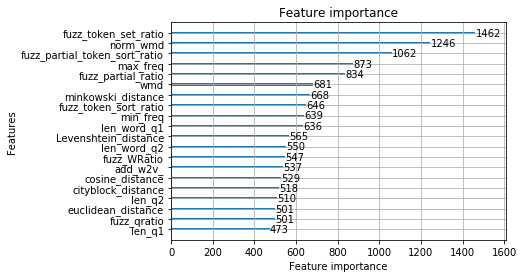

In [12]:
from lightgbm import plot_importance

plot_importance(lgbm, max_num_features=20)
plt.savefig('wiki_feature_importance')